In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()
tv = TfidfVectorizer(max_features=5000)

In [2]:
rating = pd.read_csv('dataset/tourism_rating.csv')
tourism = pd.read_csv('dataset/tourism_with_id.csv')
user = pd.read_csv('dataset/user.csv')

In [3]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [4]:
tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [5]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [6]:
rating.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64

In [7]:
tourism.isnull().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
Unnamed: 11     437
Unnamed: 12       0
dtype: int64

In [8]:
user.isnull().sum()

User_Id     0
Location    0
Age         0
dtype: int64

In [9]:
# Check how many rows and columns in this dataset
# Check if there's any duplicated row in this dataset (Duplicated rows may affect our analysis)

print(f"Rows, Columns = {rating.shape}")

print(f"\nDuplicated rows in this dataset = {rating.duplicated().any()}")

print(f"Rows, Columns = {tourism.shape}")

print(f"\nDuplicated rows in this dataset = {tourism.duplicated().any()}")

print(f"Rows, Columns = {user.shape}")

print(f"\nDuplicated rows in this dataset = {user.duplicated().any()}")

Rows, Columns = (10000, 3)

Duplicated rows in this dataset = True
Rows, Columns = (437, 13)

Duplicated rows in this dataset = False
Rows, Columns = (300, 3)

Duplicated rows in this dataset = False


In [10]:
# If there is any duplicated rows, we have to eliminate them to prevent overfit
if rating.duplicated().any():
    print(f"Duplicated rows total = {rating.duplicated().sum()}")
    display(rating[rating.duplicated()].sort_values(by = 'User_Id'))
    rating = rating.drop_duplicates()

Duplicated rows total = 79


,User_Id,Place_Id,Place_Ratings
29,1,328,2
129,5,321,3
144,5,301,2
166,6,64,5
187,7,213,3
...,...,...,...
9626,289,413,1
9682,291,91,3
9690,291,431,4
9814,295,403,1


In [11]:
# Check any duplicated data after cleaning dataset

print(f"Any duplicated rows in dataset =  {rating.duplicated().any()}")

Any duplicated rows in dataset =  False


In [12]:
# Check any duplicated data after cleaning dataset

print(f"Any duplicated rows in dataset =  {rating.duplicated().any()}")

Any duplicated rows in dataset =  False


In [13]:
# Check the data types of all the columns

tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [14]:
# convert columns to appropriate data type

tourism.astype({'Category':'string','City':'string'}).dtypes

Place_Id          int64
Place_Name       object
Description      object
Category         string
City             string
Price             int64
Rating          float64
Time_Minutes    float64
Coordinate       object
Lat             float64
Long            float64
Unnamed: 11     float64
Unnamed: 12       int64
dtype: object

{'whiskers': [<matplotlib.lines.Line2D at 0x26adf414880>,
 'caps': [<matplotlib.lines.Line2D at 0x26adfb090f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x26adf4145e0>],
 'medians': [<matplotlib.lines.Line2D at 0x26adf4151e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x26adf415480>],
 'means': []}

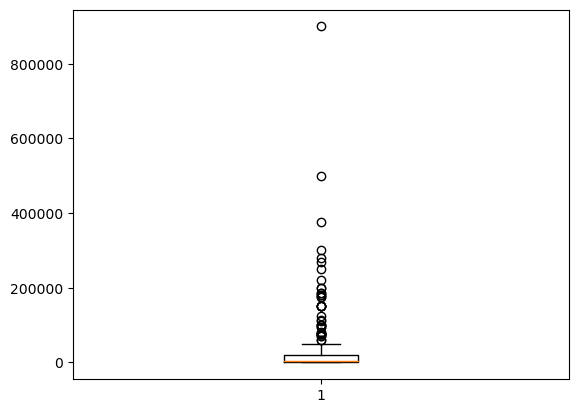

In [15]:
# remove outliers

import matplotlib.pyplot as plt
plt.boxplot(tourism['Price'])

In [16]:
# sort DataFrame by price column in descending order
tourism_sorted = tourism.sort_values('Price', ascending=False)

# print sorted DataFrame
display(tourism_sorted)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
13,14,Pulau Pelangi,Pulau Pelangi adalah sebuah pulau yang terleta...,Bahari,Jakarta,900000,4.8,NaN,"{'lat': -5.587055, 'lng': 106.5885}",-5.587055,106.588500,NaN,14
143,144,Goa Jomblang,Gua Jomblang merupakan gua vertikal yang berti...,Cagar Alam,Yogyakarta,500000,4.6,NaN,"{'lat': -8.0281562, 'lng': 110.6383307}",-8.028156,110.638331,NaN,144
296,297,Mountain View Golf Club,Selamat Datang di Mountain View Golf Club Dago...,Cagar Alam,Bandung,375000,4.4,120.0,"{'lat': -6.8629384, 'lng': 107.6482191}",-6.862938,107.648219,NaN,297
71,72,Waterboom PIK (Pantai Indah Kapuk),Waterbom Jakarta merupakan sebuah wahana perma...,Taman Hiburan,Jakarta,300000,4.4,NaN,"{'lat': -6.113655899999999, 'lng': 106.7478596}",-6.113656,106.747860,NaN,72
213,214,Trans Studio Bandung,Trans Studio Bandung adalah kawasan wisata ter...,Taman Hiburan,Bandung,280000,4.5,240.0,"{'lat': -6.9250943, 'lng': 107.6364944}",-6.925094,107.636494,NaN,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58,Taman Ayodya,"Taman Ayodya, yang dulu bernama Taman Barito, ...",Taman Hiburan,Jakarta,0,4.4,45.0,"{'lat': -6.245229400000001, 'lng': 106.7946655}",-6.245229,106.794665,NaN,58
309,310,Taman Bunga Cihideung,Taman Bunga Cihideung mempunyai pesona alam ya...,Cagar Alam,Bandung,0,4.1,45.0,"{'lat': -6.8038883, 'lng': 107.5866313}",-6.803888,107.586631,NaN,310
56,57,Taman Lapangan Banteng,"Lapangan Banteng, dulu bernama Waterlooplein (...",Taman Hiburan,Jakarta,0,4.7,NaN,"{'lat': -6.170554999999999, 'lng': 106.8350378}",-6.170555,106.835038,NaN,57
313,314,Tafso Barn,Nama Punclut mungkin sudah cukup akrab di teli...,Cagar Alam,Bandung,0,4.2,180.0,"{'lat': -6.8426446, 'lng': 107.6228408}",-6.842645,107.622841,NaN,314


<function matplotlib.pyplot.show(close=None, block=None)>

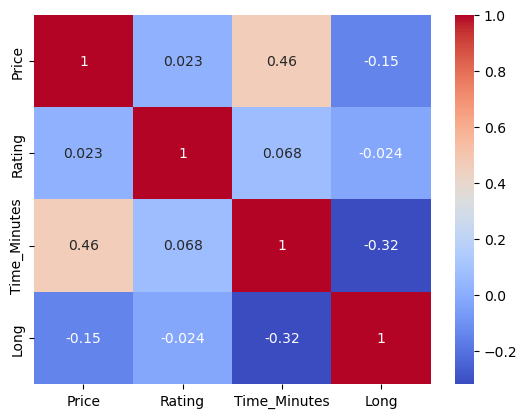

In [17]:
# find the correlation between important predictors(Price, Rating, Time_Minutes, and Long)

selected_variables = tourism[['Price','Rating','Time_Minutes','Long']]
corr_matrix = selected_variables.corr()

sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.show

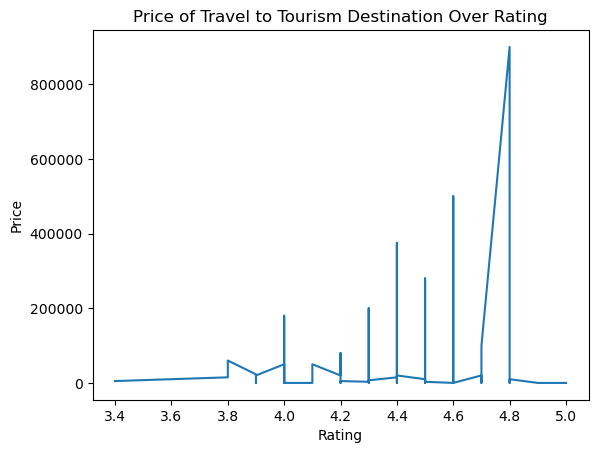

In [18]:
# Sort the data by Rating in ascending order
tourism_sorted = tourism.sort_values(by='Rating')

# Create a line graph of Price over Rating
plt.plot(tourism_sorted['Rating'], tourism_sorted['Price'])
plt.xlabel('Rating')
plt.ylabel('Price')
plt.title('Price of Travel to Tourism Destination Over Rating')
plt.show()

In [19]:
# drop the column from the dataset
tourism.drop(['Rating','Time_Minutes','Coordinate','Lat','Long','Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)
tourism

,Place_Id,Place_Name,Description,Category,City,Price
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


In [20]:
# groups the data by the 'Place_Id' column and then calculates the mean (average) of the 'Place_Ratings' column for each group and then result a new dataset

rating_tourism = pd.merge(rating.groupby('Place_Id')['Place_Ratings'].mean(),tourism,on='Place_Id')
rating_tourism

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price
0,1,3.722222,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,2.840000,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,2.526316,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,2.857143,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,3.520000,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...,...
432,433,3.304348,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,2.400000,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,3.000000,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,3.090909,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


In [21]:
def preprocessing(data):
    # converts all characters in the data variable to lowercase
    data = data.lower()

    # removes suffixes and prefixes from words
    data = stem.stem(data)

    # to remove stopwords from the data
    data = stopword.remove(data)
    return data

In [22]:
# creates a copy of the DataFrame
data_content_based_filtering = rating_tourism.copy()

# create a new column 'Tags', which combines the 'Description' and 'Category' columns.
data_content_based_filtering['Tags'] = data_content_based_filtering['Description'] + ' ' + data_content_based_filtering['Category']

# removed columns
data_content_based_filtering.drop(['Price','Place_Ratings','Description','Category','City'],axis=1,inplace=True)

data_content_based_filtering

,Place_Id,Place_Name,Tags
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu..."
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...
...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...


In [23]:
# preprocessing

data_content_based_filtering.Tags = data_content_based_filtering.Tags.apply(preprocessing)
data_content_based_filtering

,Place_Id,Place_Name,Tags
0,1,Monumen Nasional,monumen nasional populer singkat monas tugu mo...
1,2,Kota Tua,kota tua jakarta juga nama kota tua pusat alun...
2,3,Dunia Fantasi,dunia fantasi sebut dufan tempat hibur letak k...
3,4,Taman Mini Indonesia Indah (TMII),taman mini indonesia indah rupa suatu kawasan ...
4,5,Atlantis Water Adventure,atlantis water adventure kenal atlantis ancol ...
...,...,...,...
432,433,Museum Mpu Tantular,museum negeri mpu tantular buah museum negeri ...
433,434,Taman Bungkul,taman bungkul taman wisata kota letak pusat ko...
434,435,Taman Air Mancur Menari Kenjeran,air mancur tari dancing fountain ada kawasan j...
435,436,Taman Flora Bratang Surabaya,taman flora salah satu taman kota surabaya rup...


In [24]:
# convert text data into numerical vectors

vectors = tv.fit_transform(data_content_based_filtering.Tags).toarray()
vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
similarity = cosine_similarity(vectors)
similarity[0][1:10]

array([0.04510993, 0.07188361, 0.02807929, 0.00479488, 0.01497397,
       0.02458836, 0.00394491, 0.01975822, 0.01633207])

In [26]:
# based on content similarity, and returns a list of recommended locations sorted by their similarity scores

def recommend_by_content_based_filtering(location):
    location_index = data_content_based_filtering[data_content_based_filtering['Place_Name']==location].index[0]
    distances = similarity[location_index]
    location_list = sorted(list(enumerate(distances)),key=lambda x: x[1],reverse=True)[1:10]

    recommended_location = []
    for i in location_list:
        recommended_location.append([data_content_based_filtering.iloc[i[0]].Place_Name]+[i[1]])

    return recommended_location

In [27]:
destination = input("What is the place you would like to go: ")
recommend_by_content_based_filtering(destination)

What is the place you would like to go: Monumen Nasional


[['Monumen Bandung Lautan Api', 0.28683907306335177],
 ['Monumen Selamat Datang', 0.2661577967639709],
 ['Monumen Perjuangan Rakyat Jawa Barat', 0.2572969236200625],
 ['Tugu Muda Semarang', 0.22491138935052768],
 ['Monumen Bambu Runcing Surabaya', 0.2048265287412909],
 ['Monumen Tugu Pahlawan', 0.18791275217429565],
 ['Monumen Sanapati', 0.17953354994103773],
 ['Monumen Yogya Kembali', 0.178710730012256],
 ['Monumen Palagan Ambarawa', 0.1687109484122933]]

In [28]:
# copy the dataset

data_collaborative_filtering = rating.copy()
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [29]:
# Convert userIDs to a list without matching values
user_ids = data_collaborative_filtering['User_Id'].unique().tolist()
print('list userID: ', user_ids)

# Encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# encoding numbers into the userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded numbers into userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [30]:
# Convert placeID to a list without matching values
place_ids = data_collaborative_filtering['Place_Id'].unique().tolist()

# Encoding placeID
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}

# encoding numbers into the placeID
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

In [31]:
# Mapping userID to user dataframe
data_collaborative_filtering['user'] = data_collaborative_filtering['User_Id'].map(user_to_user_encoded)

# Mapping userID to place dataframe
data_collaborative_filtering['place'] = data_collaborative_filtering['Place_Id'].map(place_to_place_encoded)

In [32]:
# get the number of users
num_users = len(user_to_user_encoded)
print(num_users)

# get the number of places
num_place = len(place_encoded_to_place)
print(num_place)

# convert the Place_Ratings' datatype
data_collaborative_filtering['Place_Ratings'] = data_collaborative_filtering['Place_Ratings'].values.astype(np.float32)

# Minimum rating value
min_rating = min(data_collaborative_filtering['Place_Ratings'])

# Maximum rating value
max_rating = max(data_collaborative_filtering['Place_Ratings'])

print('Number of User: {}, Number of Place: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_place, min_rating, max_rating
))

300
437
Number of User: 300, Number of Place: 437, Min Rating: 1.0, Max Rating: 5.0


In [33]:
# shuffles the rows in a random order

data_collaborative_filtering = data_collaborative_filtering.sample(frac=1, random_state=42)
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings,user,place
5315,161,260,2.0,160,259
518,17,262,2.0,16,54
4362,133,191,5.0,132,240
8447,255,156,1.0,254,241
9105,274,78,3.0,273,35
...,...,...,...,...,...
5782,174,296,3.0,173,154
5237,159,69,4.0,158,406
5437,164,24,5.0,163,74
871,28,131,5.0,27,70


In [34]:
# prepares data for collaborative filtering

x = data_collaborative_filtering[['user', 'place']].values

# Create a variable y to create a rating from the results
y = data_collaborative_filtering['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split into 80% train data and 20% validation data
train_indices = int(0.8 * data_collaborative_filtering.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[160 259]
 [ 16  54]
 [132 240]
 ...
 [163  74]
 [ 27  70]
 [220  63]] [0.25 0.25 1.   ... 1.   1.   0.5 ]


In [35]:
# defines a neural network model for collaborative filtering-based recommendation
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.place_embedding = layers.Embedding(
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    place_vector = self.place_embedding(inputs[:, 1])
    place_bias = self.place_bias(inputs[:, 1])

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x)

In [36]:
# Model initialization

model = RecommenderNet(num_users, num_place, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [37]:
# Start training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
992/992 [==============================] - 8s 5ms/step - loss: 0.6946 - root_mean_squared_error: 0.3453 - val_loss: 0.6946 - val_root_mean_squared_error: 0.3502
Epoch 2/100
992/992 [==============================] - 5s 5ms/step - loss: 0.6873 - root_mean_squared_error: 0.3400 - val_loss: 0.6943 - val_root_mean_squared_error: 0.3500
Epoch 3/100
992/992 [==============================] - 5s 5ms/step - loss: 0.6818 - root_mean_squared_error: 0.3360 - val_loss: 0.6962 - val_root_mean_squared_error: 0.3513
Epoch 4/100
992/992 [==============================] - 6s 6ms/step - loss: 0.6762 - root_mean_squared_error: 0.3318 - val_loss: 0.6976 - val_root_mean_squared_error: 0.3523
Epoch 5/100
992/992 [==============================] - 6s 6ms/step - loss: 0.6725 - root_mean_squared_error: 0.3292 - val_loss: 0.7001 - val_root_mean_squared_error: 0.3540
Epoch 6/100
992/992 [==============================] - 5s 5ms/step - loss: 0.6677 - root_mean_squared_error: 0.3257 - val_loss: 0.7021 

992/992 [==============================] - 2s 2ms/step - loss: 0.6482 - root_mean_squared_error: 0.3112 - val_loss: 0.7293 - val_root_mean_squared_error: 0.3717
Epoch 49/100
992/992 [==============================] - 2s 2ms/step - loss: 0.6477 - root_mean_squared_error: 0.3109 - val_loss: 0.7294 - val_root_mean_squared_error: 0.3718
Epoch 50/100
992/992 [==============================] - 3s 3ms/step - loss: 0.6492 - root_mean_squared_error: 0.3119 - val_loss: 0.7298 - val_root_mean_squared_error: 0.3719
Epoch 51/100
992/992 [==============================] - 3s 3ms/step - loss: 0.6499 - root_mean_squared_error: 0.3124 - val_loss: 0.7289 - val_root_mean_squared_error: 0.3714
Epoch 52/100
992/992 [==============================] - 3s 3ms/step - loss: 0.6488 - root_mean_squared_error: 0.3115 - val_loss: 0.7294 - val_root_mean_squared_error: 0.3718
Epoch 53/100
992/992 [==============================] - 2s 2ms/step - loss: 0.6489 - root_mean_squared_error: 0.3114 - val_loss: 0.7300 - val_r

992/992 [==============================] - 2s 2ms/step - loss: 0.6490 - root_mean_squared_error: 0.3116 - val_loss: 0.7322 - val_root_mean_squared_error: 0.3735
Epoch 96/100
992/992 [==============================] - 3s 3ms/step - loss: 0.6487 - root_mean_squared_error: 0.3114 - val_loss: 0.7324 - val_root_mean_squared_error: 0.3736
Epoch 97/100
992/992 [==============================] - 3s 3ms/step - loss: 0.6493 - root_mean_squared_error: 0.3120 - val_loss: 0.7327 - val_root_mean_squared_error: 0.3737
Epoch 98/100
992/992 [==============================] - 4s 4ms/step - loss: 0.6477 - root_mean_squared_error: 0.3108 - val_loss: 0.7313 - val_root_mean_squared_error: 0.3729
Epoch 99/100
992/992 [==============================] - 5s 5ms/step - loss: 0.6492 - root_mean_squared_error: 0.3118 - val_loss: 0.7308 - val_root_mean_squared_error: 0.3725
Epoch 100/100
992/992 [==============================] - 3s 3ms/step - loss: 0.6500 - root_mean_squared_error: 0.3124 - val_loss: 0.7310 - val_

In [38]:
place_df = tourism
df = rating

user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [39]:
# Identifies places that a specific user has not visited, encodes these places into numerical values

place_not_visited = place_df[~place_df['Place_Id'].isin(place_visited_by_user.Place_Id.values)]['Place_Id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [40]:
ratings = model.predict(user_place_array).flatten()

13/13 [==============================] - 1s 4ms/step


In [41]:
# find the list for the top-rated places.

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

In [42]:
# Output

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 12)
print('Place with high ratings from user')
print('----' * 12)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

place_df_rows = place_df[place_df['Place_Id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.Place_Name)

print('----' * 12)
print('\nTop 10 Place Recommendation')
print('----' * 12)

recommended_place = place_df[place_df['Place_Id'].isin(recommended_place_ids)]
for row in recommended_place.itertuples():
    print(row.Place_Name)

Showing recommendations for users: 261
Place with high ratings from user
------------------------------------------------
Museum Taman Prasasti
Museum Tekstil
Blue Lagoon Jogja
Bendung Lepen
Observatorium Bosscha
------------------------------------------------

Top 10 Place Recommendation
------------------------------------------------
Kampung Cina
Bukit Wisata Pulepayung
Pantai Ngrawe (Mesra)
Pantai Baron
Pasar Kebon Empring Bintaran
Pintoe Langit Dahromo
Candi Ijo
Dago Dreampark
Stone Garden Citatah
Taman Hiburan Rakyat
